In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
os.listdir('../data/raw')

['test.csv',
 '.gitkeep',
 'data_description.txt',
 'train.csv',
 'sample_submission.csv']

In [8]:
housing = pd.read_csv('../data/raw/train.csv')
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
# Split description of features into a dictionary of feature_name:feature_description
import re

with open('../data/raw/data_description.txt') as f:
    txt = f.read()

delim = '<--split-->'
lst_features = re.split(delim, re.sub(r'\n(\w)', delim + r'\1', txt))

dct_features = {}
for feature in lst_features:
    split_desc = feature.split(':')
    feature_name = split_desc[0]
    feature_description = ':'.join(split_desc[1:])
    dct_features[feature_name] = feature_description

In [10]:
# Calculate correlation between SalePrice and numeric features
# Correlation with and without dropping 0s is calculated
# Returns 0 if the feature is categorical

y_corr = {}
for feature in housing.drop('SalePrice', axis=1).drop('Id', axis=1).columns:
    if housing[feature].dtype != 'O':
        filtered_set = housing[housing[feature] != 0]
        corr_matrix = housing[['SalePrice', feature]].corr()
        corr_matrix2 = filtered_set[['SalePrice', feature]].corr()
        y_corr[feature] = (corr_matrix.loc['SalePrice', feature], corr_matrix2.loc['SalePrice', feature])
    else:
        y_corr[feature] = (0, 0)
        
y_corr = pd.DataFrame.from_dict(y_corr, orient='index', columns=['corr', 'nozero'])
y_corr

,corr,nozero
MSSubClass,-0.084284,-0.084284
MSZoning,0.000000,0.000000
LotFrontage,0.351799,0.351799
LotArea,0.263843,0.263843
Street,0.000000,0.000000
...,...,...
MiscVal,-0.021190,0.088963
MoSold,0.046432,0.046432
YrSold,-0.028923,-0.028923
SaleType,0.000000,0.000000


In [11]:
# Display description, statistics and feature plots all in one frame
# dct_keep is used to determine whether to keep this feature or not

# %matplotlib inline

# from sklearn.preprocessing import LabelEncoder

# nunique_values = housing.nunique().sort_values(ascending=False)

# dct_keep = {}

# for feature_name, corrs in y_corr['nozero'].sort_values(ascending=False).iteritems():

#     # Print feature description, number of unique values and correlation with sale price
#     if feature_name in dct_features.keys():
#          print('%s: %s' % (feature_name, dct_features[feature_name]))
#     else:
#          print(feature_name)
#     print('%s unique values' % nunique_values[feature_name])
#     print('Correlation with sale price:\n', y_corr.loc[feature_name])
    
#     # Plot
#     fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    
#     # Figure 1 (left)
#     housing[feature_name].hist(bins=50, ax=ax[0])
    
#     # Figure 2 (right)
#     if housing[feature_name].dtype != 'O':
#         housing.plot.scatter(y='SalePrice', x=feature_name, ax=ax[1], alpha=0.1)
#     else:
#         le = LabelEncoder()
#         encoded_feature = pd.DataFrame(
#             {'SalePrice': housing['SalePrice'],
#              feature_name: le.fit_transform(housing[feature_name].fillna('NA') )
#             })
        
#         encoded_feature.plot.scatter(y='SalePrice', x=feature_name, ax=ax[1], alpha=0.1)
    
#     plt.tight_layout()
#     plt.show()

#     # Keep?
#     dct_keep[feature_name] = input('Keep feature? y/n')

# s_dct_keep = pd.Series(dct_keep, name='to_keep')
# s_dct_keep.to_csv('../data/interim/features_to_keep.csv', header=True)

In [20]:
s_dct_keep = pd.read_csv('../data/interim/features_to_keep.csv', index_col=0)['to_keep']
s_dct_keep[['ExterQual', 'HeatingQC', 'FireplaceQu', 'Fence', 'GarageQual']] = 'y'
s_dct_keep = s_dct_keep[s_dct_keep == 'y']
to_keep = s_dct_keep.index

# Now using only the selected features

In [22]:
# Filter data 
housing = pd.read_csv('../data/raw/train.csv')
housing = housing[['SalePrice'] + list(to_keep)]
housing.columns

pd.set_option('max_rows', None)
nunique_values = housing.nunique().sort_values(ascending=False)
print(nunique_values)
pd.set_option('max_rows', 10)

GrLivArea       861
1stFlrSF        753
TotalBsmtSF     721
SalePrice       663
BsmtFinSF1      637
GarageArea      441
2ndFlrSF        417
YearBuilt       112
GarageYrBlt      97
YearRemodAdd     61
Neighborhood     25
MSSubClass       15
TotRmsAbvGrd     12
OverallQual      10
Foundation        6
GarageQual        5
HeatingQC         5
FireplaceQu       5
GarageCars        5
KitchenQual       4
LandContour       4
Fence             4
BsmtQual          4
ExterQual         4
Fireplaces        4
FullBath          4
dtype: int64


OverallQual:  Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
	
10 unique values
Correlation with sale price:
 corr      0.790982
nozero    0.790982
Name: OverallQual, dtype: float64


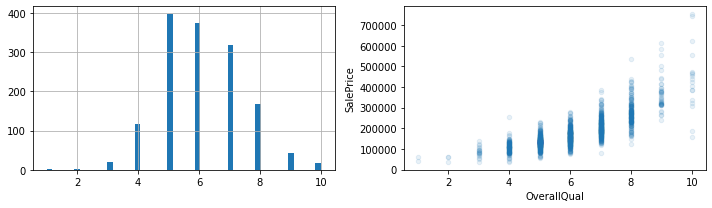

GrLivArea:  Above grade (ground) living area square feet

861 unique values
Correlation with sale price:
 corr      0.708624
nozero    0.708624
Name: GrLivArea, dtype: float64


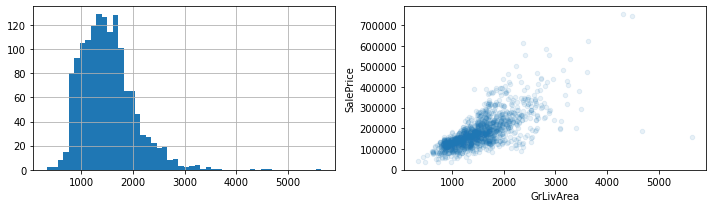

2ndFlrSF:  Second floor square feet

417 unique values
Correlation with sale price:
 corr      0.319334
nozero    0.673305
Name: 2ndFlrSF, dtype: float64


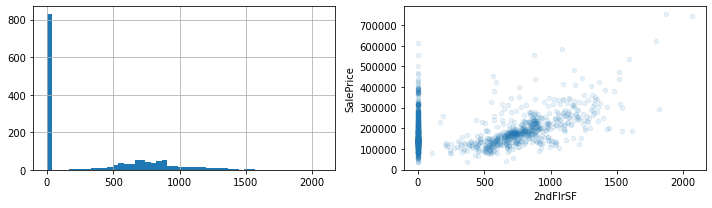

GarageCars:  Size of garage in car capacity

5 unique values
Correlation with sale price:
 corr      0.640409
nozero    0.637095
Name: GarageCars, dtype: float64


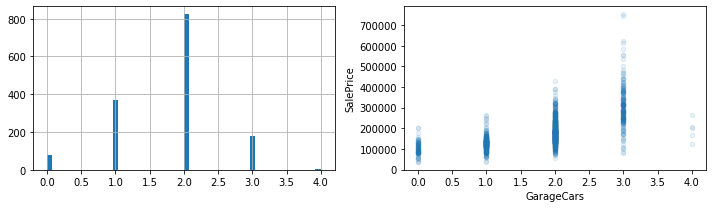

TotalBsmtSF:  Total square feet of basement area

721 unique values
Correlation with sale price:
 corr      0.613581
nozero    0.609681
Name: TotalBsmtSF, dtype: float64


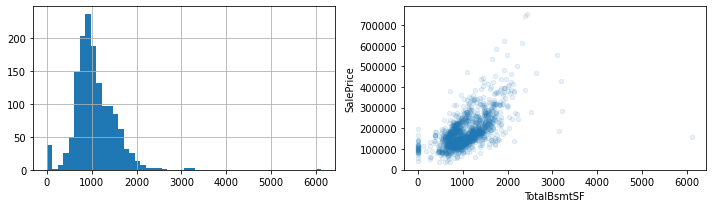

GarageArea:  Size of garage in square feet

441 unique values
Correlation with sale price:
 corr      0.623431
nozero    0.608405
Name: GarageArea, dtype: float64


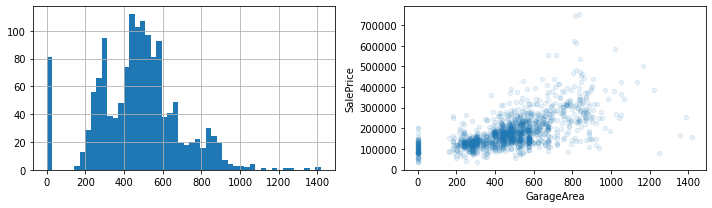

1stFlrSF:  First Floor square feet
 
753 unique values
Correlation with sale price:
 corr      0.605852
nozero    0.605852
Name: 1stFlrSF, dtype: float64


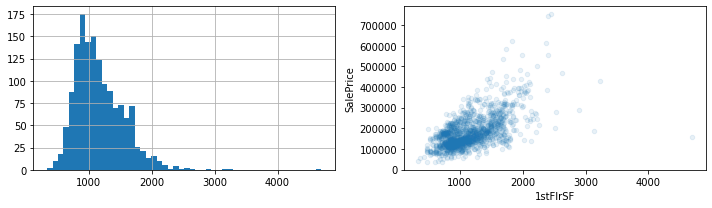

FullBath:  Full bathrooms above grade

4 unique values
Correlation with sale price:
 corr      0.560664
nozero    0.574563
Name: FullBath, dtype: float64


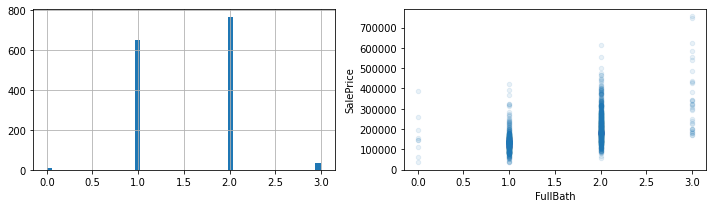

TotRmsAbvGrd:  Total rooms above grade (does not include bathrooms)

12 unique values
Correlation with sale price:
 corr      0.533723
nozero    0.533723
Name: TotRmsAbvGrd, dtype: float64


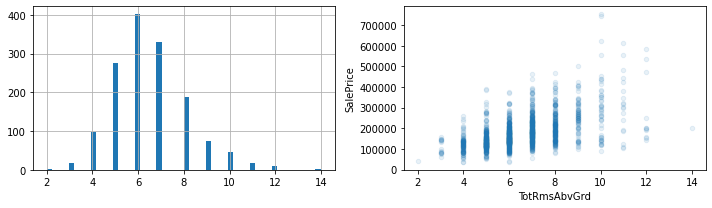

YearBuilt:  Original construction date

112 unique values
Correlation with sale price:
 corr      0.522897
nozero    0.522897
Name: YearBuilt, dtype: float64


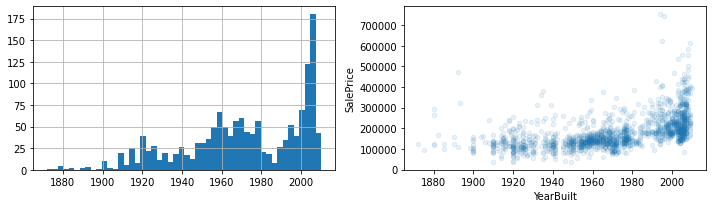

YearRemodAdd:  Remodel date (same as construction date if no remodeling or additions)

61 unique values
Correlation with sale price:
 corr      0.507101
nozero    0.507101
Name: YearRemodAdd, dtype: float64


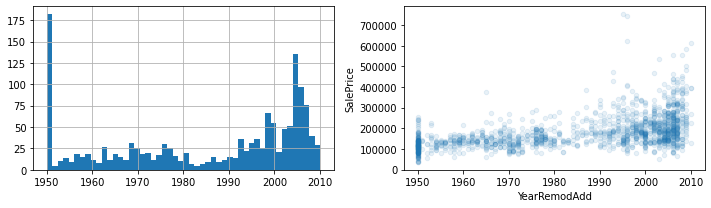

GarageYrBlt:  Year garage was built
		
97 unique values
Correlation with sale price:
 corr      0.486362
nozero    0.486362
Name: GarageYrBlt, dtype: float64


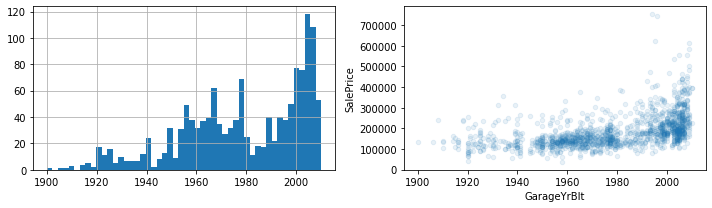

BsmtFinSF1:  Type 1 finished square feet

637 unique values
Correlation with sale price:
 corr      0.38642
nozero    0.47169
Name: BsmtFinSF1, dtype: float64


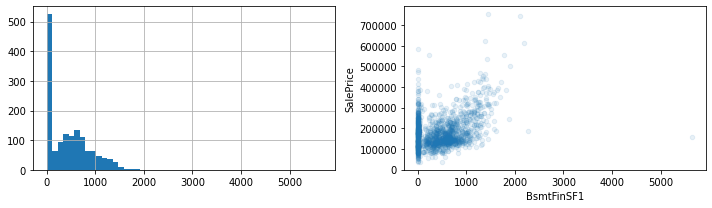

Fireplaces:  Number of fireplaces

4 unique values
Correlation with sale price:
 corr      0.466929
nozero    0.121661
Name: Fireplaces, dtype: float64


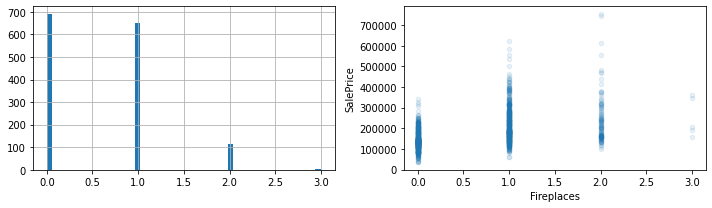

HeatingQC:  Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
5 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: HeatingQC, dtype: float64


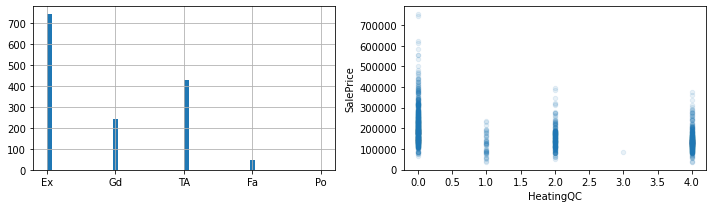

Neighborhood:  Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker
			
25 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Neighborhood, dtype: float64


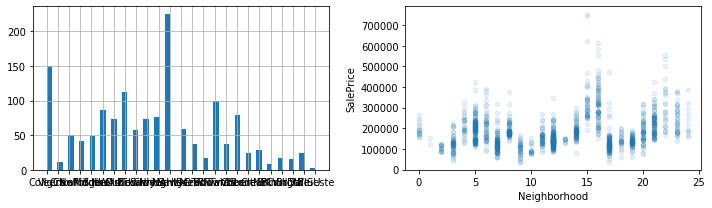

LandContour:  Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: LandContour, dtype: float64


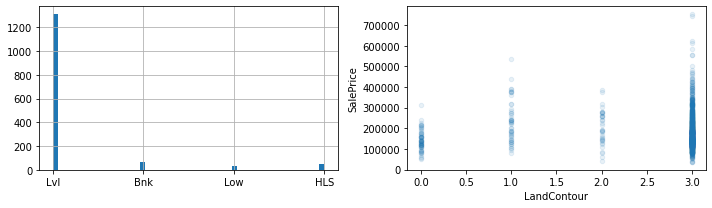

ExterQual:  Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: ExterQual, dtype: float64


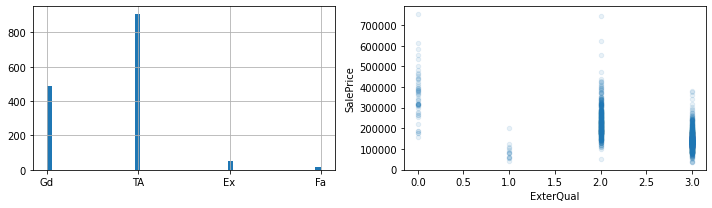

Foundation:  Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
		
6 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Foundation, dtype: float64


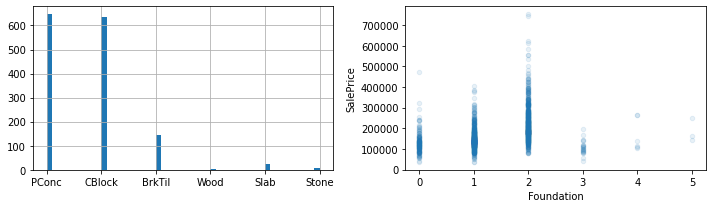

BsmtQual:  Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: BsmtQual, dtype: float64


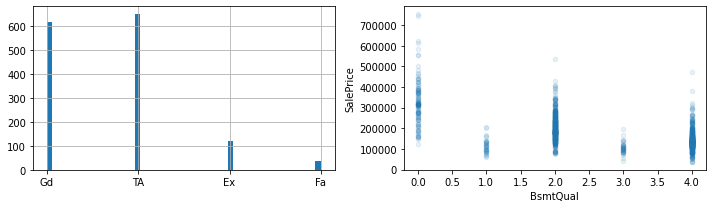

Fence:  Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
	
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Fence, dtype: float64


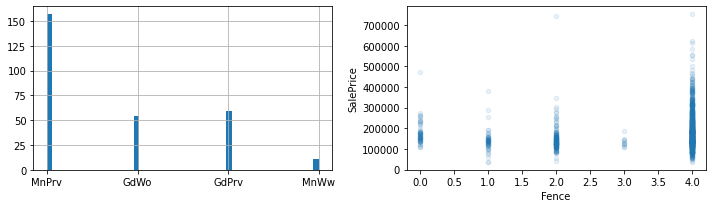

GarageQual:  Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
5 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: GarageQual, dtype: float64


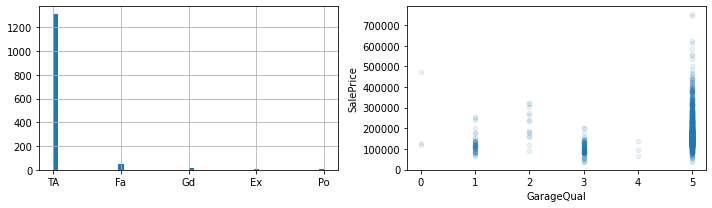

FireplaceQu:  Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
		
5 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: FireplaceQu, dtype: float64


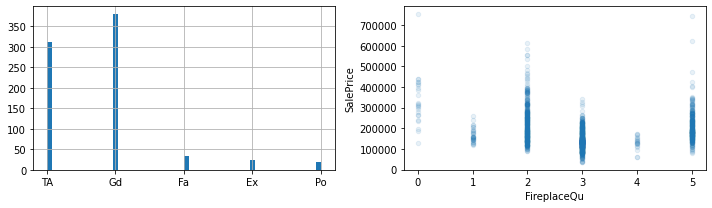

KitchenQual:  Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       	
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: KitchenQual, dtype: float64


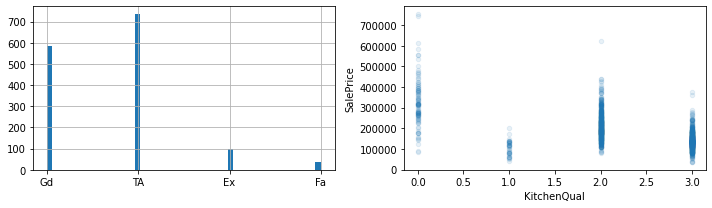

MSSubClass:  Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

15 unique values
Correlation with sale price:
 corr     -0.084284
nozero   -0.084284
Name: MSSubClass, dtype: float64


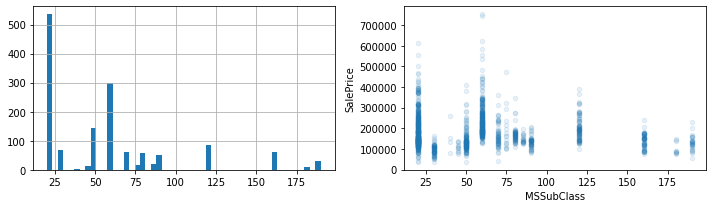

In [23]:
# Same plot as earlier, using only interesting features
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

nunique_values = housing.nunique().sort_values(ascending=False)

for feature_name, corrs in y_corr['nozero'][to_keep].sort_values(ascending=False).iteritems():

    # Print feature description, number of unique values and correlation with sale price
    if feature_name in dct_features.keys():
         print('%s: %s' % (feature_name, dct_features[feature_name]))
    else:
         print(feature_name)
    print('%s unique values' % nunique_values[feature_name])
    print('Correlation with sale price:\n', y_corr.loc[feature_name])
    
    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    
    # Figure 1 (left)
    housing[feature_name].hist(bins=50, ax=ax[0])
    
    # Figure 2 (right)
    if housing[feature_name].dtype != 'O':
        housing.plot.scatter(y='SalePrice', x=feature_name, ax=ax[1], alpha=0.1)
    else:
        le = LabelEncoder()
        encoded_feature = pd.DataFrame(
            {'SalePrice': housing['SalePrice'],
             feature_name: le.fit_transform(housing[feature_name].fillna('NA') )
            })
        
        encoded_feature.plot.scatter(y='SalePrice', x=feature_name, ax=ax[1], alpha=0.1)
    
    plt.tight_layout()
    plt.show()

### House size

/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: 

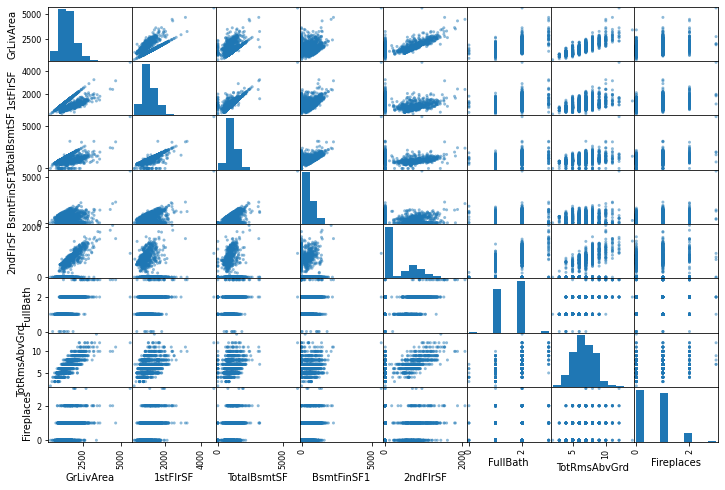

In [24]:
from pandas.plotting import scatter_matrix

living_area = housing[['SalePrice', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'BsmtFinSF1',
                         '2ndFlrSF', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces']].copy()
scatter_matrix(living_area.drop('SalePrice', axis=1), figsize=(12, 8))
plt.show()

GrLivArea seems to determine the size of 1st floor, basement, 2nd floor and total number of rooms.
- 1stFlrSF: perfectly linear (when there is only one floor)
- 2ndFlrSF: mostly linear (when there is a 2nd floor)
- Basement: If there is one then price increase

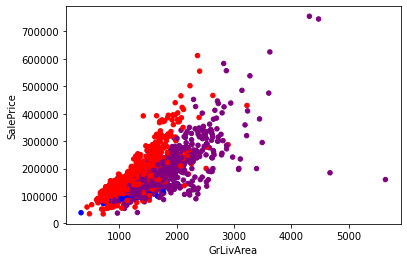

In [25]:
living_area['is2nd'] = living_area['2ndFlrSF'] > 0
living_area['color'] = np.where(
    living_area['2ndFlrSF'] > 0, 'purple', np.where(
        living_area['TotalBsmtSF'] > 0, 'red', np.where(
            living_area['1stFlrSF'] > 0, 'blue', 'black'
        ))).copy()

living_area.plot.scatter(y='SalePrice', x='GrLivArea', c=living_area['color'])

In [26]:
# Simple linear regression model

from sklearn.linear_model import LinearRegression

def lin_reg(X, y):
    lr = LinearRegression()

    from sklearn.model_selection import cross_validate
    scores = cross_validate(lr, X, y, scoring=["neg_mean_squared_error", "r2"], cv=10)
    rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
    r2 = scores['test_r2']
    r2_adj = 1 - (1 - r2) * (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1)
    
    print('RMSE: (%f, %f)' % (rmse.mean(), rmse.std()))
    print('r2: (%f, %f)' % (r2.mean(), r2.std()))
    print('r2-adj: (%f, %f)' % (r2_adj.mean(), r2_adj.std()))

In [27]:
X = living_area[['GrLivArea']]
y = living_area['SalePrice']

lin_reg(X, y)

RMSE: (55616.283215, 8313.475161)
r2: (0.499674, 0.080594)
r2-adj: (0.499331, 0.080650)


In [28]:
X = living_area[['GrLivArea', 'is2nd']]
y = living_area['SalePrice']

lin_reg(X, y)

RMSE: (51759.474778, 8183.174119)
r2: (0.565355, 0.083839)
r2-adj: (0.564759, 0.083954)


In [29]:
X = living_area[['TotalBsmtSF', '2ndFlrSF']]
y = living_area['SalePrice']

lin_reg(X, y)

RMSE: (51928.236039, 11797.267068)
r2: (0.560059, 0.152600)
r2-adj: (0.559455, 0.152810)


In [30]:
X = living_area[['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FullBath', 'Fireplaces']]
y = living_area['SalePrice']

lin_reg(X, y)

RMSE: (47145.304498, 11237.499937)
r2: (0.636153, 0.134530)
r2-adj: (0.634902, 0.134993)


#### Conclusion:

##### Use:
    - TotalBsmtSF, 1stFlrSF and 2ndFlrSF together
    - FullBath (number of bathrooms)
    - Fireplaces
    
##### Drop:
    - GrLivArea
    - TotalBsmtSF
    - BsmtFinSF1

### Garage correlated features

/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: 

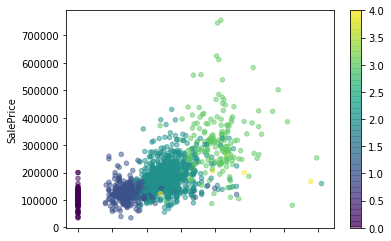

In [31]:
garage = housing[['SalePrice', 'GarageArea', 'GarageCars', 'GarageYrBlt']].copy()

garage.plot.scatter(y='SalePrice', x='GarageArea',
                    c=garage['GarageCars'],
                    colormap='viridis', alpha=0.5)

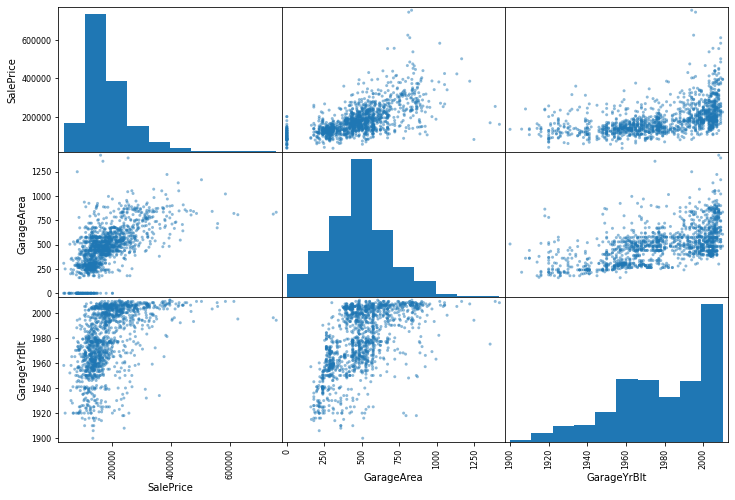

In [32]:
scatter_matrix(garage.drop('GarageCars', axis=1), figsize=(12, 8));

#### Conclusion:

##### Use:
    - GarageCars
    
##### Drop:
    - GarageArea
    - GarageYrBlt

### Quality

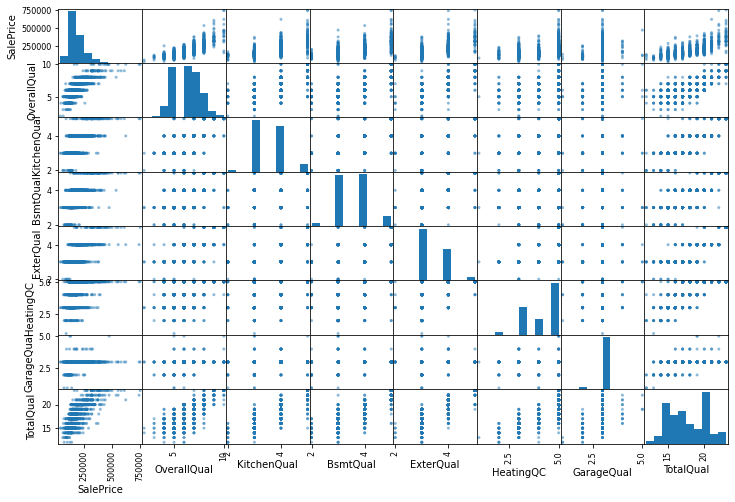

In [33]:
quality = housing[['SalePrice', 'OverallQual', 'KitchenQual', 'BsmtQual',
                     'ExterQual', 'HeatingQC', 'GarageQual']].dropna()

quality_map = {'Ex': 5,
               'Gd': 4,
               'TA': 3,
               'Fa': 2,
               'Po': 1}

qual_cols = ['KitchenQual', 'BsmtQual', 'ExterQual', 'HeatingQC', 'GarageQual']

for col in qual_cols:
    quality[col] = quality[col].map(quality_map)

quality['TotalQual'] = quality[qual_cols].sum(axis=1)

scatter_matrix(quality, figsize=(12, 8));

In [34]:
X = quality[['OverallQual']]
y = quality['SalePrice']

lin_reg(X, y)

RMSE: (48746.370435, 5775.121769)
r2: (0.613322, 0.043381)
r2-adj: (0.613035, 0.043413)


In [35]:
X = quality[['KitchenQual', 'BsmtQual', 'ExterQual', 'HeatingQC', 'GarageQual']]
y = quality['SalePrice']

lin_reg(X, y)

RMSE: (51890.282842, 6116.016924)
r2: (0.562432, 0.042724)
r2-adj: (0.560803, 0.042883)


In [36]:
X = quality[['OverallQual', 'KitchenQual']]
y = quality['SalePrice']

lin_reg(X, y)

RMSE: (46872.069457, 5738.518095)
r2: (0.642459, 0.043382)
r2-adj: (0.641927, 0.043446)


#### Conclusion:

##### Use:
    - OverallQual
    - KitchenQual
    
##### Drop:
    - BsmtQual
    - ExterQual
    - HeatingQC
    - GarageQual

# Preprocessing

In [37]:
housing = pd.read_csv('../data/raw/train.csv')

num_features = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'OverallQual', 'YearBuilt']
num_cat_features = ['Fireplaces', 'GarageCars', 'FullBath']
cat_features = ['KitchenQual', 'Neighborhood', 'MSSubClass', 'Foundation']

### Cat features

/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: 

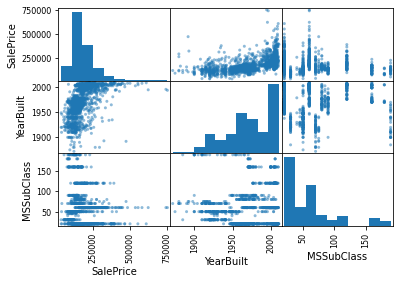

In [38]:
housing_cat = housing[['SalePrice', 'YearBuilt'] + cat_features].copy()

scatter_matrix(housing_cat)
plt.show()

#### MSSubClass

In [39]:
# Convert to category
housing_cat['MSSubClass'] = housing_cat['MSSubClass'].astype('category')

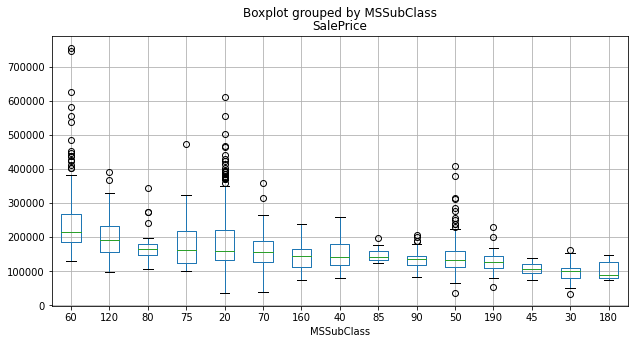

[(60, 299), (120, 87), (80, 58), (75, 16), (20, 536), (70, 60), (160, 63), (40, 4), (85, 20), (90, 52), (50, 144), (190, 30), (45, 12), (30, 69), (180, 10)]

 Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES



In [40]:
## 1. Normal boxplot

# Order by mean SalePrice
ordered_MS = housing_cat.groupby('MSSubClass').median().sort_values(by='SalePrice', ascending=False).index
housing_cat['MSSubClass'] = housing_cat['MSSubClass'].cat.reorder_categories(list(ordered_MS))

# Boxplot
housing_cat.boxplot(column='SalePrice', by='MSSubClass', figsize=(10, 5))
plt.show()

# Value counts
print(list(dict(housing_cat['MSSubClass'].value_counts().sort_index()).items()), end='\n\n')

# Feature description
print(dct_features['MSSubClass'])

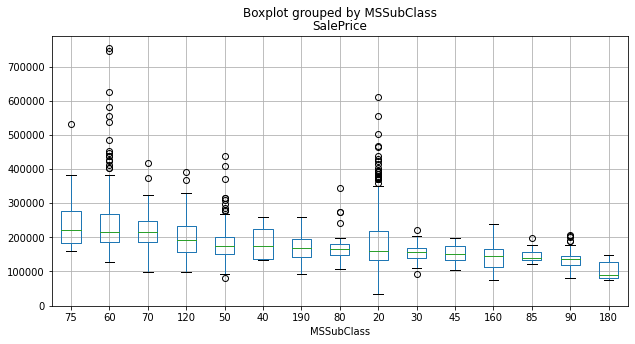

[(60, 299), (120, 87), (80, 58), (75, 16), (20, 536), (70, 60), (160, 63), (40, 4), (85, 20), (90, 52), (50, 144), (190, 30), (45, 12), (30, 69), (180, 10)]

 Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES



In [41]:
## 2. Adjust price based on before or after 1945

old_build = housing.loc[housing['YearBuilt'] <= 1945, 'SalePrice'].mean()
new_build = housing.loc[housing['YearBuilt'] >= 1946, 'SalePrice'].mean()
price_diff = new_build - old_build

housing_cat_adj = housing_cat.copy()
housing_cat_adj.loc[housing_cat_adj['YearBuilt'] <= 1945, 'SalePrice'] += price_diff

# Order by mean SalePrice
ordered_MS = housing_cat_adj.groupby('MSSubClass').median().sort_values(by='SalePrice', ascending=False).index
housing_cat_adj['MSSubClass'] = housing_cat_adj['MSSubClass'].cat.reorder_categories(list(ordered_MS))

# Boxplot
housing_cat_adj.boxplot(column='SalePrice', by='MSSubClass', figsize=(10, 5))
plt.show()

# Value counts
print(list(dict(housing_cat['MSSubClass'].value_counts().sort_index()).items()), end='\n\n')

# Feature description
print(dct_features['MSSubClass'])

In [42]:
housing_cat['1-STORY'] = housing_cat['MSSubClass'].isin([20, 30, 40, 120])
housing_cat['1-1/2-STORY'] = housing_cat['MSSubClass'].isin([45, 50, 150])
housing_cat['2-STORY'] = housing_cat['MSSubClass'].isin([60, 70, 160])
housing_cat['2-1/2-STORY'] = housing_cat['MSSubClass'].isin([75])
housing_cat['SPLIT'] = housing_cat['MSSubClass'].isin([80, 85, 180])
housing_cat['PUD'] = housing_cat['MSSubClass'].isin([120, 150, 160, 180])
housing_cat['DUPLEX'] = housing_cat['MSSubClass'].isin([90])
housing_cat['2FAMILY'] = housing_cat['MSSubClass'].isin([190])

#### Quality

In [43]:
quality_map = {'Ex': 5,
               'Gd': 4,
               'TA': 3,
               'Fa': 2,
               'Po': 1}

housing_cat['KitchenQual'] = housing_cat['KitchenQual'].map(quality_map)

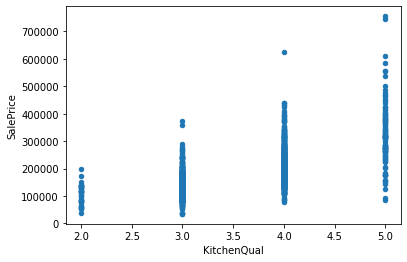

In [44]:
housing_cat.plot.scatter(y='SalePrice', x='KitchenQual');

#### Foundation and Neighborhood

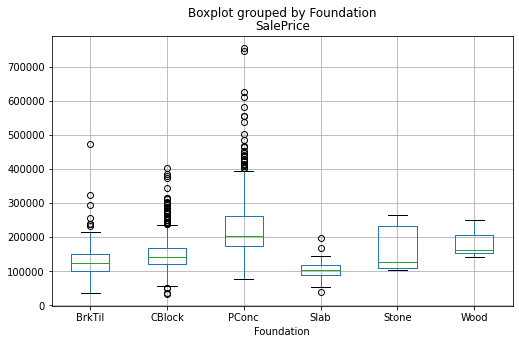

In [45]:
housing_cat.boxplot(column='SalePrice', by='Foundation', figsize=(8, 5));

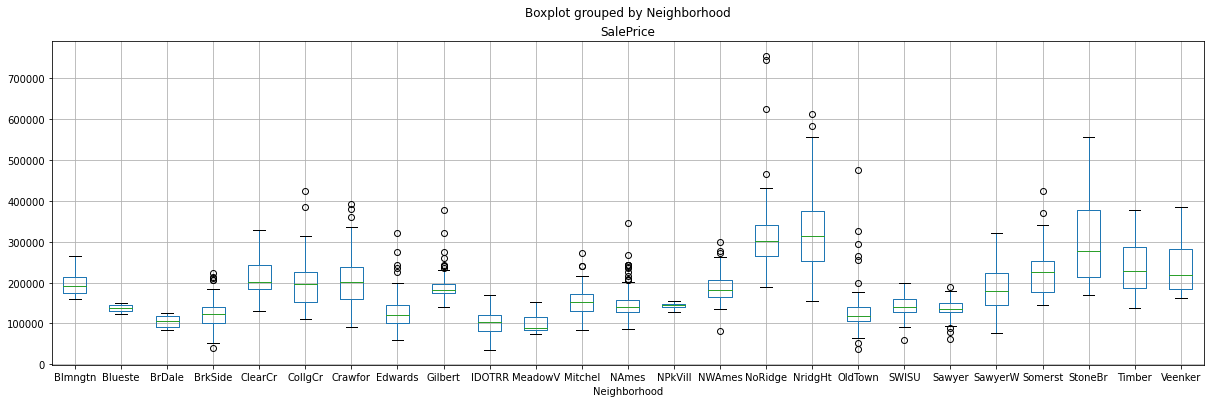

In [46]:
housing_cat.boxplot(column='SalePrice', by='Neighborhood', figsize=(20, 6));

In [48]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit_transform(housing_cat[['Foundation', 'Neighborhood']])

<1460x31 sparse matrix of type '<class 'numpy.float64'>'
	with 2920 stored elements in Compressed Sparse Row format>

### Numeric cat features

/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: 

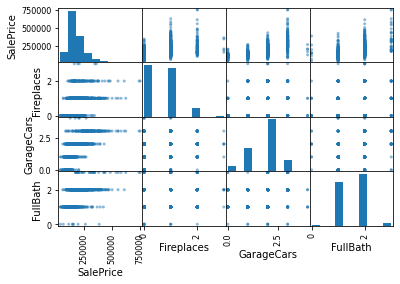

In [49]:
housing_num_cat = housing[['SalePrice'] + num_cat_features].copy()

scatter_matrix(housing_num_cat)
plt.show()

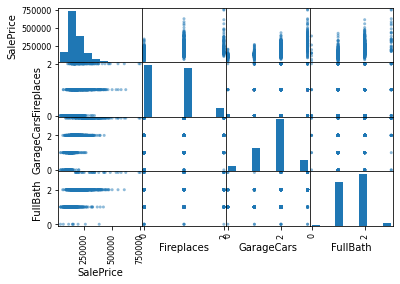

In [50]:
# Combine categorical feature instances with low frequency
housing_num_cat.loc[housing_num_cat['Fireplaces'] > 2, 'Fireplaces'] = 2
housing_num_cat.loc[housing_num_cat['GarageCars'] > 3, 'GarageCars'] = 3

scatter_matrix(housing_num_cat)
plt.show()

### Numeric features

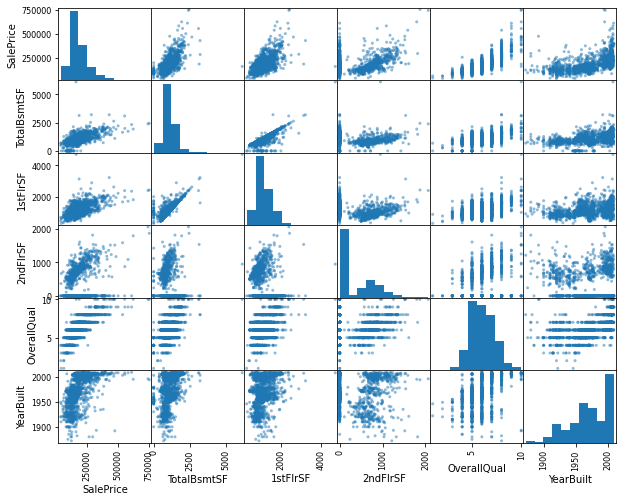

In [51]:
housing_num = housing[['SalePrice'] + num_features]

scatter_matrix(housing_num, figsize=(10, 8))
plt.show()

# Pipeline 

In [52]:
housing = pd.read_csv('../data/raw/train.csv')
housing.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [53]:
# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    housing.drop('SalePrice', axis=1),
    housing['SalePrice']
)

In [54]:
# Numeric transformer
from sklearn.base import BaseEstimator, TransformerMixin

class DiscreteCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, idx_Fireplaces, idx_GarageCars):
        self.idx_Fireplaces = idx_Fireplaces
        self.idx_GarageCars = idx_GarageCars
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = np.array(X)
        X[X[:, self.idx_Fireplaces] > 2, self.idx_Fireplaces] = 2
        X[X[:, self.idx_GarageCars] > 3, self.idx_GarageCars] = 3
        return X        

In [55]:
# Categorical to numeric transformer
class QualityMapper(BaseEstimator, TransformerMixin):
    def __init__(self, idx_KitchenQual):
        self.idx_KitchenQual = idx_KitchenQual
        quality_map = {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1
        }
        self.map_quality = np.vectorize(quality_map.get)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = np.array(X)
        X[:, idx_KitchenQual] = self.map_quality(X[:, idx_KitchenQual])
        
        return X

In [56]:
# Numeric pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_features = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'OverallQual', 'YearBuilt',
                'FullBath', 'Fireplaces', 'GarageCars', 'KitchenQual']

idx_fireplaces = num_features.index('Fireplaces')
idx_garagecars = num_features.index('GarageCars')
idx_KitchenQual = num_features.index('KitchenQual')

num_pipeline = Pipeline([
    ('quality_mapper', QualityMapper(idx_KitchenQual)),
    ('discrete_cleaner', DiscreteCleaner(idx_fireplaces, idx_garagecars)),
    ('std_scaler', StandardScaler())
])

In [57]:
# Categorical custom OHE
from sklearn.base import BaseEstimator, TransformerMixin

class MSSubClassOHE(BaseEstimator, TransformerMixin):
    def __init__(self, idx_MSSubClass):
        self.idx_MSSubClass = idx_MSSubClass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = np.array(X)
        one_story = np.isin(X[:, idx_MSSubClass], [20, 30, 40, 120])
        one_half_story = np.isin(X[:, idx_MSSubClass], [45, 50, 150])
        two_story = np.isin(X[:, idx_MSSubClass], [60, 70, 160])
        two_half_story = np.isin(X[:, idx_MSSubClass], [75])
        split = np.isin(X[:, idx_MSSubClass], [80, 85, 180])
        pud = np.isin(X[:, idx_MSSubClass], [120, 150, 160, 180])
        duplex = np.isin(X[:, idx_MSSubClass], [90])
        two_family = np.isin(X[:, idx_MSSubClass], [190])
        
        return np.c_[np.delete(X, idx_MSSubClass, axis=1), one_story, one_half_story,
                     two_story, two_half_story, split, pud, duplex, two_family]       
    

In [58]:
# Categorical custom OHE pipeline
cat_features = ['MSSubClass']

idx_MSSubClass = cat_features.index('MSSubClass')

cat_pipeline = Pipeline([
    ('ms_subclass_simplifier', MSSubClassOHE(idx_MSSubClass)),
])

In [59]:
# OHE pipeline 
from sklearn.preprocessing import OneHotEncoder

ohe_features = ['Neighborhood', 'Foundation']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
    ('ohe', OneHotEncoder(), ohe_features),
])

X_train_pp = full_pipeline.fit_transform(X_train)

# Modeling 

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, X_train_pp, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

rmse_scores.mean()

34824.403873419746

In [61]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

scores = cross_val_score(rf_reg, X_train_pp, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

rmse_scores.mean()

29542.487422391936

In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'bootstrap': [False, True], 
     'n_estimators': [20, 30, 40, 50, 60],
     'max_features': [2, 4, 6, 8]
    },
]

rf_reg = RandomForestRegressor()
grid_search = GridSearchCV(
    rf_reg,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search.fit(X_train_pp, y_train)

print(grid_search.best_params_, end='\n\n')

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'bootstrap': False, 'max_features': 4, 'n_estimators': 40}

30225.676277231807 {'bootstrap': False, 'max_features': 2, 'n_estimators': 20}
29905.955867163797 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
30198.67538880828 {'bootstrap': False, 'max_features': 2, 'n_estimators': 40}
29247.509398898317 {'bootstrap': False, 'max_features': 2, 'n_estimators': 50}
28640.255725477757 {'bootstrap': False, 'max_features': 2, 'n_estimators': 60}
29098.112733856466 {'bootstrap': False, 'max_features': 4, 'n_estimators': 20}
29675.40325793297 {'bootstrap': False, 'max_features': 4, 'n_estimators': 30}
28310.65538444599 {'bootstrap': False, 'max_features': 4, 'n_estimators': 40}
29085.25025948366 {'bootstrap': False, 'max_features': 4, 'n_estimators': 50}
29101.612365889112 {'bootstrap': False, 'max_features': 4, 'n_estimators': 60}
29896.17320990828 {'bootstrap': False, 'max_features': 6, 'n_estimators': 20}
28935.161949578258 {'bootstrap': False, 'max_features': 6, 'n_estimators': 

In [63]:
# Random Forest feature importances
feature_importances = grid_search.best_estimator_.feature_importances_

mssubclass_features = ['one_story', 'one_half_story', 'two_story', 'two_half_story', 'split',
                       'pud', 'duplex', 'two_family'] 

ohe_encoder = full_pipeline.named_transformers_["ohe"]
ohe_features = list(np.concatenate(ohe_encoder.categories_))

feature_names = num_features + mssubclass_features + ohe_features 

sorted(zip(feature_importances, feature_names), reverse=True)

[(0.1630004242992526, 'TotalBsmtSF'),
 (0.11420760979656434, 'OverallQual'),
 (0.10009234468990372, '1stFlrSF'),
 (0.08965368350311552, 'YearBuilt'),
 (0.08614984005561048, 'KitchenQual'),
 (0.07940340915491313, 'GarageCars'),
 (0.06886352497754818, 'FullBath'),
 (0.06023751981423984, '2ndFlrSF'),
 (0.05231667728858204, 'Fireplaces'),
 (0.025624493788521614, 'PConc'),
 (0.024401106479513664, 'NridgHt'),
 (0.017793317813470485, 'two_story'),
 (0.013624450942854338, 'CBlock'),
 (0.013493990904201284, 'NoRidge'),
 (0.00809200993529143, 'Edwards'),
 (0.007738621908534906, 'one_story'),
 (0.005987963089676843, 'StoneBr'),
 (0.005897181314425876, 'pud'),
 (0.005443061673787687, 'CollgCr'),
 (0.005312943437622725, 'Crawfor'),
 (0.004974937782234214, 'NAmes'),
 (0.004875553313712087, 'BrkTil'),
 (0.004289867039961147, 'one_half_story'),
 (0.004286478497154257, 'OldTown'),
 (0.0033262371773792104, 'Somerst'),
 (0.0032828824760100356, 'duplex'),
 (0.002677641641776706, 'ClearCr'),
 (0.0023912011

In [64]:
X_train_pp[0]

array([ 1.80492498,  2.18433035, -0.79796446,  1.40103844,  1.14298087,
        0.81824924,  2.16703167,  1.68909185,  0.75396447,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ])

In [65]:
X_test_pp[0]

NameError: name 'X_test_pp' is not defined

In [ ]:
X_test_pp = full_pipeline.transform(X_test)

y_pred = grid_search.best_estimator_.predict(X_test_pp)
test_mse = mean_squared_error(y_test, y_pred)
np.sqrt(test_mse)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]